In [ ]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import random as rn
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm as tqdm
import shutil

import time
from contextlib import contextmanager
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Mounting the drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Declaring the variables
currentDirectory = "/content/drive/My Drive/VQA_Project/"
dataDirectory = currentDirectory + "Data/"
train_imageDirectory = "/content/drive/My Drive/Train/train2014/"
train_imageNumpyDirectory = dataDirectory + "Train/train2014_Numpy/"
modelsDirectory = currentDirectory + "Models/"
img_width = 224
img_height = 224

BATCH_SIZE = 30
BUFFER_SIZE = 300

In [ ]:
# Reading the training dataset 
train_data = pd.read_csv(dataDirectory + 'train_data.csv')

In [ ]:
# Extracting the sample records of 300000 from data set file  due to memory constraints
train_data_sample = train_data.sort_values(by=['image_id'],ascending=False).head(300000)

In [ ]:
# Splitting the data set
X_train, X_val = train_test_split(train_data_sample, test_size=0.2, random_state=42)

##**1. Creating Answer Vectors**

In [ ]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = str(text)
    text = text.lower()
    i = 0
    for word in text.split():
      if i==0:
        new_text = contractions.get(word,word)
      else:
        new_text = new_text + " " + contractions.get(word,word)
      i += 1
    return new_text.replace("'s", '')

In [ ]:
X_train['multiple_choice_answer'] = X_train['multiple_choice_answer'].apply(lambda x: preprocess_english(x))
X_val['multiple_choice_answer'] = X_val['multiple_choice_answer'].apply(lambda x: preprocess_english(x))

In [ ]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

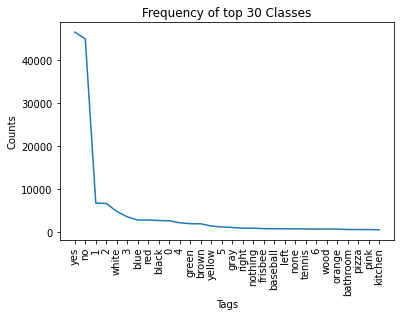

In [ ]:
sort_class_frequency = sorted(list(class_frequency.items()),key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

5 most frequent Classes covers 45.33% points
10 most frequent Classes covers 51.47% points
20 most frequent Classes covers 57.28% points
50 most frequent Classes covers 64.01% points
70 most frequent Classes covers 66.59% points
100 most frequent Classes covers 69.46% points
200 most frequent Classes covers 75.29% points
500 most frequent Classes covers 82.83% points
750 most frequent Classes covers 85.58% points
1000 most frequent Classes covers 87.37% points
2000 most frequent Classes covers 91.00% points
3000 most frequent Classes covers 92.80% points
5000 most frequent Classes covers 94.57% points


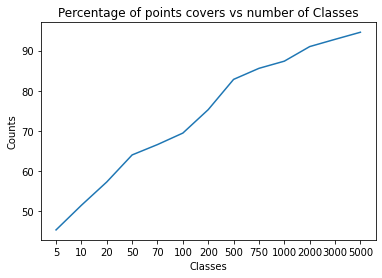

In [ ]:
def getPercentageOfDataCoversGivenNumClasses(n_class, class_frequency, df):
    n_common_class = heapq.nlargest(n_class, class_frequency, key=class_frequency.get)
    count = 0
    for _class in df['multiple_choice_answer'].values:
        if(_class in n_common_class):
            count += 1

    return (count/len(df))*100
    
n_classes = [5,10,20,50,70,100,200,500,750,1000,2000,3000,5000]
percentage_cover = []
for i in n_classes:
    temp = getPercentageOfDataCoversGivenNumClasses(i,class_frequency,train_data)
    percentage_cover.append(temp)
    print("{} most frequent Classes covers {:.2f}% points".format(i,temp))


plt.plot(percentage_cover)
i=np.arange(len(percentage_cover))
plt.title("Percentage of points covers vs number of Classes")
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.xticks(i,n_classes)
plt.show()

In [ ]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

#removing question which has empty tags for training data
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [ ]:
X_val['multiple_choice_answer'] =  X_val['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

#removing question which has empty tags for training data
X_val = X_val[X_val['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [ ]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (210479, 1000)
Shape of Answer Vectors in Validation Data:  (52264, 1000)


## **2. Creating Image Features using VGG 19**

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_width, img_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = img * (1./255)
    return img, image_path

def VGG19_Top():
    model = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape = (img_width, img_height,3))
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

def generateImageFeatures(images):
    model = VGG19_Top()
    all_image_dict = {}
    img_ds = tf.data.Dataset.from_tensor_slices(images)
    img_ds = img_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

    for batch_img, batch_path in img_ds:
        batch_img_features = model(batch_img)

        for img_features, path in zip(batch_img_features, batch_path):
            image_path = path.numpy().decode("utf-8")
            #image_path = image_path.replace(train_imageDirectory,train_imageNumpyDirectory).replace('.jpg',"")
            #np.save(image_path, img_features.numpy())
            all_image_dict[image_path] = img_features.numpy()
            print(len(all_image_dict))

    with open(dataDirectory + 'all_image_dict2.pickle', 'wb') as handle:
        pickle.dump(all_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return

In [ ]:
all_image_path = train_data_sample['image_id'].apply(lambda x:  train_imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).unique()

In [ ]:
len(all_image_path)

55965

In [ ]:
generateImageFeatures(all_image_path)

Streaming output truncated to the last 5000 lines.
50966
50967
50968
50969
50970
50971
50972
50973
50974
50975
50976
50977
50978
50979
50980
50981
50982
50983
50984
50985
50986
50987
50988
50989
50990
50991
50992
50993
50994
50995
50996
50997
50998
50999
51000
51001
51002
51003
51004
51005
51006
51007
51008
51009
51010
51011
51012
51013
51014
51015
51016
51017
51018
51019
51020
51021
51022
51023
51024
51025
51026
51027
51028
51029
51030
51031
51032
51033
51034
51035
51036
51037
51038
51039
51040
51041
51042
51043
51044
51045
51046
51047
51048
51049
51050
51051
51052
51053
51054
51055
51056
51057
51058
51059
51060
51061
51062
51063
51064
51065
51066
51067
51068
51069
51070
51071
51072
51073
51074
51075
51076
51077
51078
51079
51080
51081
51082
51083
51084
51085
51086
51087
51088
51089
51090
51091
51092
51093
51094
51095
51096
51097
51098
51099
51100
51101
51102
51103
51104
51105
51106
51107
51108
51109
51110
51111
51112
51113
51114
51115
51116
51117
51118
51119
51120
51121
51122
51123
5

In [ ]:
# Reading the generated image features from pickle
with open(dataDirectory + 'all_image_dict2.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)

In [ ]:
image_paths_train = X_train['image_id'].apply(lambda x:  train_imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  train_imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values

## **3. Creating Question Vectors**

In [ ]:
def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
      new_text = new_text + " " + contractions.get(word,word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [ ]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_english(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_english(x))

In [ ]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)
val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])

print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)
print("Shape of Question Vectors in Validation Data: ", question_vector_val.shape)

Number of words in tokenizer: 10843
Shape of Question Vectors in Train Data:  (210479, 24)
Shape of Question Vectors in Validation Data:  (52264, 24)


## **4. Creating Datasets**

In [ ]:
def get_imageTensor(img, ques):
    #path = img.decode('utf-8').replace(train_imageDirectory,train_imageNumpyDirectory).replace('.jpg',"") +'.npy'
    #img_tensor = np.load(path)
    img_tensor = all_image_dict[img.decode('utf-8')]
    return img_tensor, ques

In [ ]:
def createDataset(image_paths,question_vector,answer_vector):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32)))
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vector.astype(np.float32)))
    # using map to load the numpy files in parallel
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(get_imageTensor, [img, ques], [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(type(dataset_input))
    # shuffling and batching
    #dataset_input = dataset_input.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset_input = dataset_input.batch(BATCH_SIZE)
    dataset_output = dataset_output.batch(BATCH_SIZE)#.repeat()
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
dataset_train = createDataset(image_paths_train, question_vector_train, answer_vector_train)
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val)

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>


# **Base Line Model**

In [ ]:
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)
##python RS
rn.seed(12)

In [ ]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = modelsDirectory + ModelName + "/best04.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3)
    #early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)

    #directory for tensorboard to save evnts
    log_dir= modelsDirectory + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    history = tf.keras.callbacks.History()
   # callbacks_list = [reduce_lr, early_stop, history, tensorboard_callback, checkpoint]
    callbacks_list = [reduce_lr, history, tensorboard_callback, checkpoint]
    return callbacks_list

def Build_BaseModel():
    image_input = tf.keras.layers.Input(shape=(7,7,512))
    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    image_conv_layer1 = tf.keras.layers.Conv2D(filters = 4096, kernel_size = 7 , strides = 1, padding = "valid", activation = 'relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=45))(image_input)

    image_flatten = tf.keras.layers.Flatten()(image_conv_layer1)

    image_dense_1 = tf.keras.layers.Dense(4096, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=54))(image_flatten)
    
    image_dense_2 = tf.keras.layers.Dense(1024, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=32))(image_dense_1)


    # Input 2 Pathway
    print(len(tokenizer.word_index))
    question_emb = tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 300 ,name = "Embedding_Layer",
                                             embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))(question_input)

    question_lstm = tf.keras.layers.LSTM(1024, 
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54),
                                         bias_initializer=tf.keras.initializers.zeros())(question_emb)

    question_flatten = tf.keras.layers.Flatten(name="Flatten_lstm")(question_lstm)

    
    image_question = tf.keras.layers.Multiply()([image_dense_2, question_flatten])


    image_question_dense_1 = tf.keras.layers.Dense(1000, activation = tf.nn.relu,
                                                    kernel_initializer = tf.keras.initializers.he_uniform(seed=19))(image_question)
    
    image_question_dense_2 = tf.keras.layers.Dense(1000, activation = tf.nn.relu, 
                                                   kernel_initializer = tf.keras.initializers.he_uniform(seed=28))(image_question_dense_1)

    output = tf.keras.layers.Dense(len(ans_vocab), activation=tf.nn.softmax, 
                                   kernel_initializer = tf.keras.initializers.glorot_normal(seed=15))(image_question_dense_2)

    # Create Model
    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)
    # Compile
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
l2_alpha = 0.001
ModelName = "BaselineModel"
model = Build_BaseModel()
results = model.fit(dataset_train, epochs = 30, validation_data = dataset_val, callbacks = callBacksList())

10843
TensorBoard Folder for this Execution /content/drive/My Drive/VQA_Project/Models/logs/fit/BaselineModel/20201218-001624
Epoch 1/30
7016/7016 [==============================] - 641s 91ms/step - loss: 3.2165 - accuracy: 0.2673 - val_loss: 2.5189 - val_accuracy: 0.2882

Epoch 00001: val_accuracy improved from -inf to 0.28825, saving model to /content/drive/My Drive/VQA_Project/Models/BaselineModel/best04.hdf5
Epoch 2/30
7016/7016 [==============================] - 639s 91ms/step - loss: 2.4504 - accuracy: 0.3002 - val_loss: 2.2923 - val_accuracy: 0.3123

Epoch 00002: val_accuracy improved from 0.28825 to 0.31234, saving model to /content/drive/My Drive/VQA_Project/Models/BaselineModel/best04.hdf5
Epoch 3/30
7016/7016 [==============================] - 637s 91ms/step - loss: 2.2182 - accuracy: 0.3206 - val_loss: 2.1580 - val_accuracy: 0.3400

Epoch 00003: val_accuracy improved from 0.31234 to 0.34004, saving model to /content/drive/My Drive/VQA_Project/Models/BaselineModel/best04.hdf

## **Validation**

### **Training loss vs Validation Loss**

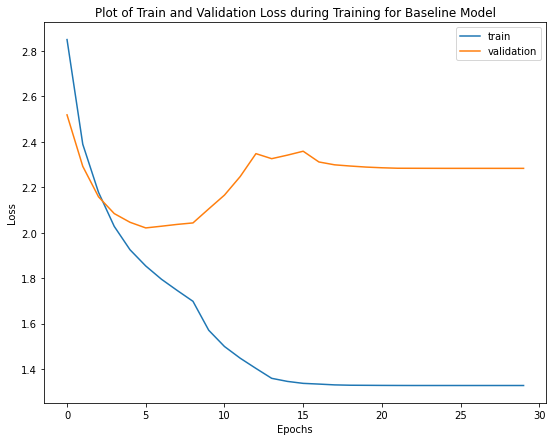

In [ ]:
# plot training history of Train and Validation Loss During model Training
from matplotlib import pyplot
pyplot.figure(figsize=(9,7))
pyplot.plot(results.history['loss'], label='train')
pyplot.plot(results.history['val_loss'], label='validation')
pyplot.title('Plot of Train and Validation Loss during Training for Baseline Model')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.show()

### **Training Accuracy vs Validation Accuracy**

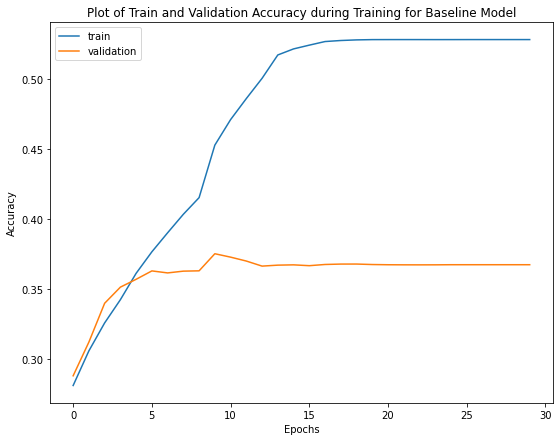

In [ ]:
# plot training history of Train and Validation accuracy During model Training
pyplot.figure(figsize=(9,7))
pyplot.plot(results.history['accuracy'], label='train')
pyplot.plot(results.history['val_accuracy'], label='validation')
pyplot.title('Plot of Train and Validation Accuracy during Training for Baseline Model')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('Accuracy')
pyplot.show()

### **Model Summary**

In [ ]:
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 1, 1, 4096)   102764544   input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 4096)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [ ]:
l2_alpha = 0.001
ModelName = "BaselineModel"
model = Build_BaseModel()
model.load_weights(modelsDirectory + ModelName + "/best04.hdf5")
model.evaluate(dataset_val)


10843
1743/1743 [==============================] - 43s 21ms/step - loss: 2.1302 - accuracy: 0.3719


[2.104769706726074, 0.3754209280014038]

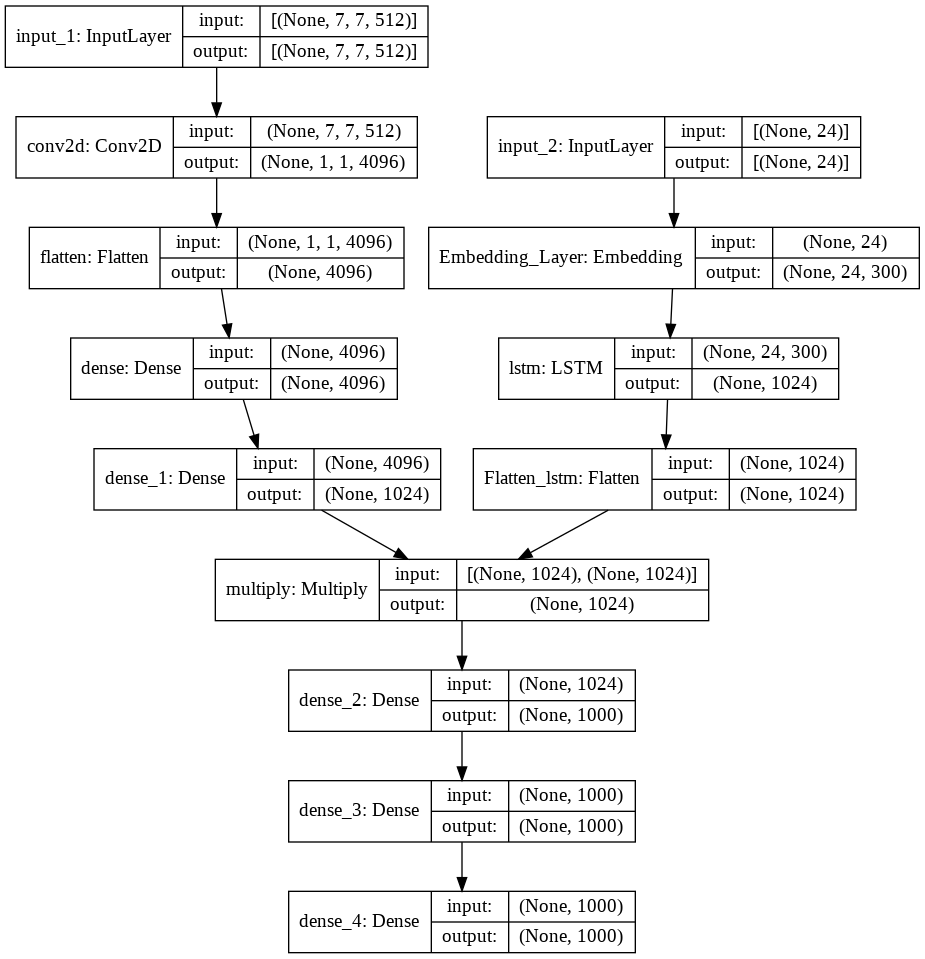

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **Verification with Validation Test Data**

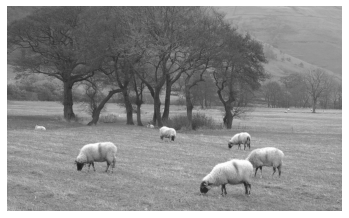

Question : are the animals planning to bite someone?
Actual Answer:  no
Top Predicted answers:  [('no', 72.98042), ('yes', 27.019545), ('down', 2.3140685e-05), ('mirror', 3.5101252e-06), ('up', 2.8687082e-06)]
******************************************************************************************************************************************************


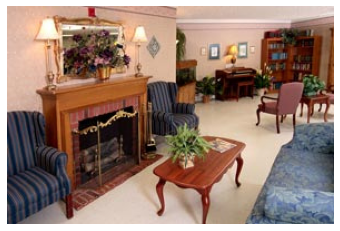

Question : is there a musical instrument?
Actual Answer:  yes
Top Predicted answers:  [('no', 60.585827), ('yes', 39.412605), ('camera', 0.00034796202), ('mirror', 0.0002913613), ('down', 0.00021222247)]
******************************************************************************************************************************************************


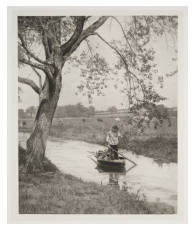

Question : is she milking a cow?
Actual Answer:  no
Top Predicted answers:  [('no', 59.229393), ('yes', 40.770603), ('closed', 2.0346833e-06), ('plane', 1.0021344e-06), ('right', 9.991857e-07)]
******************************************************************************************************************************************************


In [ ]:
model.load_weights(modelsDirectory + ModelName + "/best04.hdf5")
test_idx = np.random.randint(len(X_val), size = 3)
model_vgg = VGG19_Top()
k = 5

for idx in test_idx:
    test_image_id = X_val['image_id'].values[idx]
    test_question = X_val['question'].values[idx]
    actual_answer = X_val['multiple_choice_answer'].values[idx]
    test_image_path = train_imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (test_image_id)

    test_image_features = model_vgg(tf.expand_dims(load_image(test_image_path)[0], 0))
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=question_vector_train.shape[1])
    y_pred = model.predict([test_image_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
    percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
    predictions = []
    for idx,i in enumerate(class_indices[0]):
        classes = np.zeros((1,1000))
        classes[0][i] = 1
        predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

    img=mpimg.imread(test_image_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
    print("Actual Answer: ", actual_answer)
    print("Top Predicted answers: ",predictions)
    print("*"*150)